In [877]:
# The codes for the backtest system contains a large proportion
# transformed from the matlab codes in the homework. 
# Most original comments are remained for the Markowitz part.
# In the Black Litterman part, to avoid redundancy, only the things
# different from Markowitz have comments. 
# Comments following "#//" are codes used to debug only. They can be 
# totally ignored.

##########################################
#### * #######  PREPARAION  ####### * ####
##########################################

import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *

In [878]:
# Import data and store them in matrices
risk_free_rate = pd.read_csv(r'D:\DGS3MO_daily.csv', index_col=0, header=0)
risk_free_rate = np.array(risk_free_rate)
Price = pd.read_csv(r'D:\price_com_mat.csv', index_col=0, header=0)
Price = np.mat(Price)
nc = Price.shape[1] # number of columns

In [879]:
Super = pd.read_csv(r'D:\super_big_data.csv', index_col=0, header=0)
Returns = np.mat(Super.iloc[:,range(120,120+30,1)])
Variance = np.mat(Super.iloc[:,range(0,0+nc*3,3)])
Skewness = np.mat(Super.iloc[:,range(1,1+nc*3,3)])
Kurtosis = np.mat(Super.iloc[:,range(2,2+nc*3,3)])

In [880]:
# # The random signal here is only used to test whether the system works, it can be replaced by any signal.
# random_signal = np.random.uniform(20,100,1255*30)
# random_signal = random_signal.reshape([1255,30])
# random_signal = pd.DataFrame(random_signal,columns=range(1,31,1),index=range(1,1256,1))
# random_signal = np.mat(random_signal)

In [881]:
##########################################
#### * ########  FUNCTION  ######## * ####
##########################################

# Turn the signal matrix into a ranking matrix where the value for each entry 
# refers to the ranking of of the asset's signal among all assets' signals in
# the specific period.
# In the output matrix, each row will look like 3,24,1,535,12,18... the 3 here
# means the first asset has the third smallest signal in that period.
def ranking(signal_matrix):
    rank_matrix = np.zeros(signal_matrix.shape)
    rank_matrix = np.mat(rank_matrix)
    #rank_matrix
    nc = signal_matrix.size/len(signal_matrix)
    for i in range(len(signal_matrix)):
        data_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list.sort()  # list the signal values of each date from small to large
        rank_index=range(30)
        r=1  # rank 1 has the smallest signal value
        while(len(element_list)!=0):        
            for j in range(nc):
                if(min(element_list)==data_list[j]):
                    rank_matrix[i,j] = r
                    del element_list[0]
                    r=r+1
                    break
                    
    return rank_matrix         

In [882]:
# Very similar to the ranking function above. The only difference is that here signal 
# values are sorted and divided into groups, where assets in each group has the same 
# groupranking.
# In the output matrix, a row may look like 1,1,5,2,2,4,3,3..., which means the first 
# and second assets are in the group with smallest signal values.
# PRECONDITION: number_of_colmns%number_of_groups==0 
def ngroupranking(signal_matrix,number_of_groups):
    rank_matrix = np.zeros(signal_matrix.shape)
    grouprank_matrix = np.zeros(signal_matrix.shape)
    #print rank_matrix.dtype
    rank_matrix = np.mat(rank_matrix)
    grouprank_matrix = np.mat(grouprank_matrix)
    #rank_matrix
    nc = signal_matrix.size/len(signal_matrix)
    distance = nc/number_of_groups
    for i in range(len(signal_matrix)):
        data_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list.sort() 
        rank_index=range(30)
        r=1
        while(len(element_list)!=0):        
            for j in range(nc):
                if(min(element_list)==data_list[j]):
                    rank_matrix[i,j] = r
                    grouprank_matrix[i,j] = float(int(r-1)/int(distance)+1)
                    del element_list[0]
                    r=r+1
                    break
                    
    return rank_matrix,grouprank_matrix  

#// test = ngroupranking(Skewness,3)[1]
#// for i in range(1000):
    #// for j in range(20):
        #// if (test[i,j]!=1.0 and test[i,j]!=2.0 and test[i,j]!=3.0):
            #// print i,j,test[i,j]

In [883]:
test = ngroupranking(Skewness,2)[1]

In [884]:
test[0]

matrix([[2., 2., 2., 1., 2., 1., 2., 1., 2., 2., 1., 1., 2., 1., 1., 1.,
         1., 2., 1., 2., 1., 1., 1., 2., 1., 2., 2., 2., 2., 1.]])

In [885]:
#Calculate mu and V
##### PRECONDITION: sample_frequency*number_of_samples < trade_date  
def adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay):  
    h = horizon 
    P = Price # the Price matrix, each row refer to a date and each column refers to an asset
    t_d = trade_date # the date you trade, 0,1,2...
    s_f = sample_frequency 
    n_s = number_of_samples
    r_d = rate_of_decay

    s_d = t_d-1-np.arange(n_s+1)*s_f # reverse chronological   
    s_d = s_d[::-1] # chronological    
        # sample dates, a row vector

    S_P = P[s_d,:] # Sample Prices, a matrix
    S_C_R = np.log(S_P[1:,:]/S_P[:-1,:]) #Sample Compound Returns, a matrix
    
    # Now it ’s time to construct the weight
    w = (1.0-float(r_d))**np.arange(1,n_s+1)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])  #weights, a non-negative vector that sums to 1
    mean_c_r = S_C_R.T*wt  #mean vector of compound returns
    Cov_C_R = (S_C_R.T*np.diag(w)*S_C_R)-mean_c_r*np.transpose([mean_c_r])
    # covariance matrix of compound returns

    adapted_mean_c_r = mean_c_r*(float(h)/float(s_f))
    # adapting mean vector to reflect length of holding period
    
    Adapted_Cov_C_R = Cov_C_R*(float(h)/float(s_f))
    # adapting covariance matrix to length of holding period

    muu = np.exp(adapted_mean_c_r + 0.5*np.mat(np.diag(Adapted_Cov_C_R)).T)
    mu = muu - 1 # resulting mean vector of ARITHMETIC returns
    
    V = np.multiply((muu*np.transpose([muu.T])),(np.exp(Adapted_Cov_C_R)-1))
    # resulting covariance matrix of ARITHMETIC returns   
    
    return mu,V

In [886]:
# This function takes in a groupranking signal matrix and remains only 
# the group investor believe will outperform the market, with a coefficient
# 1 for each the assets in that group and 0 for others.
# Each row looks like 0,0,0,1,1,0,1,...
# PRECONDITION: outperforming_ranking is an integer existing in the GroupSignal
def view_ranking_signal(GroupSignal,outperforming_ranking):
    view_rank = GroupSignal
    for i in range(view_rank.shape[0]):
        for j in range(view_rank.shape[1]):
            if (view_rank[i,j]!=outperforming_ranking):
                view_rank[i,j] = 0
    view_rank = view_rank/outperforming_ranking
    
    return view_rank

In [887]:
## test, view_ranking_signal(GroupSignal,outperforming_ranking)
# // testx = [[1,3,2,4,5],[2,3,4,1,5],[2,4,5,1,3]]
# // testx = np.mat(testx)
# // testx
# // view_ranking_signal(testx,3)

In [888]:
# This function can be regarded as an additional stats function for the Black Litterman model,
# which shows the investor views through three outputs: A, Omega(which is U in lecture notes, 
# but we have used "U" for cholesky factorization, so we use another name here), and b.
# At1,At2,At3 are integers among 1,2,3, which refers to the outperforming_ranking in the 
# above view_ranking_signal function.
# PRECONDITION: Signal1, Signal2, Signal3 are of the same size.
def hybrid_investor_view(Signal1,Signal2,Signal3,At1,At2,At3,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay):
    S1 = Signal1 # the Signal matrix, each row refer to a date and each column refers to an asset
    S2 = Signal2
    S3 = Signal3
    
    R = Returns
    t_d = trade_date
    s_f = signal_sample_frequency
    n_s = number_of_signal_samples
    r_d = rate_of_signal_decay
 
    s_d = t_d-1-np.arange(n_s)*s_f
    s_d = s_d[::-1]    

    S_S1 = S1[s_d,:] #Sample Signals, a matrix
    S_S2 = S2[s_d,:]
    S_S3 = S3[s_d,:]

    S_R = R[s_d,:] #Sample Returns

    w = (1.0-float(r_d))**np.arange(n_s)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])
    mean_c_r1 = S_S1.T*wt
    mean_c_r2 = S_S2.T*wt
    mean_c_r3 = S_S3.T*wt
    #// print mean_c_r.T
    GroupSignal1 = ngroupranking(mean_c_r1.T,3)[1].T
    GroupSignal2 = ngroupranking(mean_c_r2.T,3)[1].T
    GroupSignal3 = ngroupranking(mean_c_r3.T,3)[1].T
    view_rank1 = view_ranking_signal(GroupSignal1,At1)
    view_rank2 = view_ranking_signal(GroupSignal2,At2)
    view_rank3 = view_ranking_signal(GroupSignal3,At3)
    #// print ngroupranking(mean_c_r.T,3)[1].dtype
    #// print mean_c_r.dtype
    #// print view_rank.dtype
    #// print view_rank
    var_signal1 = np.var(S_S1) # the variance of all signal values in the samples 
    var_signal2 = np.var(S_S2)
    var_signal3 = np.var(S_S3) 
    A1 = view_rank1.T
    A2 = view_rank2.T
    A3 = view_rank3.T
    A = np.mat([np.ndarray.tolist(A1[0])[0],np.ndarray.tolist(A2[0])[0],np.ndarray.tolist(A3[0])[0]])
    Omega = np.mat(np.diag([var_signal1,var_signal2,var_signal3]))    
    b1 = np.sum(S_R*A1.T)
    b2 = np.sum(S_R*A2.T)
    b3 = np.sum(S_R*A3.T)    
    b = np.mat([b1,b2,b3]).T
    
    return A,Omega,b
#// atest = investor_view(Skewness,Returns,120,1,5,0)[0]

In [889]:
# This function can be regarded as an additional stats function for the Black Litterman model,
# which shows the investor views through three outputs: A, Omega(which is U in lecture notes, 
# but we have used "U" for cholesky factorization, so we use another name here), and b.
# At1,At2 are integers among 1,2, which refers to the outperforming_ranking in the 
# above view_ranking_signal function.
# PRECONDITION: Signal1, Signal2  are of the same size.

def double_investor_view(Signal1,Signal2,At1,At2,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay):
    S1 = Signal1 # the Signal matrix, each row refer to a date and each column refers to an asset
    S2 = Signal2
    
    R = Returns
    t_d = trade_date
    s_f = signal_sample_frequency
    n_s = number_of_signal_samples
    r_d = rate_of_signal_decay
 
    s_d = t_d-1-np.arange(n_s)*s_f
    s_d = s_d[::-1]    

    S_S1 = S1[s_d,:] #Sample Signals, a matrix
    S_S2 = S2[s_d,:]

    S_R = R[s_d,:] #Sample Returns

    w = (1.0-float(r_d))**np.arange(n_s)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])
    mean_c_r1 = S_S1.T*wt
    mean_c_r2 = S_S2.T*wt
    
    
    #print mean_c_r1.T
    
    GroupSignal1 = ngroupranking(mean_c_r1.T,3)[1].T
    GroupSignal2 = ngroupranking(mean_c_r2.T,3)[1].T
    view_rank1 = view_ranking_signal(GroupSignal1,At1)
    view_rank2 = view_ranking_signal(GroupSignal2,At2)
    
    #print GroupSignal1
    #print view_rank1
    #print ngroupranking(mean_c_r1.T,3)[1]
    #// print mean_c_r.dtype
    #// print view_rank.dtype
    #// print view_rank
    var_signal1 = np.var(S_S1) # the variance of all signal values in the samples 
    var_signal2 = np.var(S_S2)
    
    A1 = view_rank1.T
    A2 = view_rank2.T
    
    #print A1
    
    A = np.mat([np.ndarray.tolist(A1[0])[0],np.ndarray.tolist(A2[0])[0]])
    Omega = np.mat(np.diag([var_signal1,var_signal2]))    
    b1 = np.sum(S_R*A1.T)
    b2 = np.sum(S_R*A2.T)   
    b = np.mat([b1,b2]).T
    
    return A,Omega,b

In [890]:
#atest = double_investor_view(Skewness,Returns,120,1,5,0)[0]
#atest=double_investor_view(Signal1,Signal2,At1,At2,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay)

In [891]:
#atest

In [892]:
# A simple version of the above function where only one signal is considered.
# When introducing the Signal matrix, the assumption is: Smaller skewness, better asset.
def investor_view(Signal,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay):
    S = Signal # the Signal matrix, each row refer to a date and each column refers to an asset
    R = Returns
    t_d = trade_date
    s_f = signal_sample_frequency
    n_s = number_of_signal_samples
    r_d = rate_of_signal_decay
 
    s_d = t_d-1-np.arange(n_s)*s_f
    s_d = s_d[::-1]    

    S_S = S[s_d,:] #Sample Signals, a matrix
    S_R = R[s_d,:] #Sample Returns

    w = (1.0-float(r_d))**np.arange(n_s)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])
    mean_c_r = S_S.T*wt
    #// print mean_c_r.T
    view_rank = ngroupranking(mean_c_r.T,3)[1].T
    #// print ngroupranking(mean_c_r.T,3)[1].dtype
    #// print mean_c_r.dtype
    #// print view_rank.dtype
    #// print view_rank
    view_rank = view_rank%3
    view_rank = view_rank%2
    ###########    View on the skewness    ########
    skewness_small = view_rank.T
    var_skewness = np.var(S_S)# the var of 
    A = skewness_small
    Omega = np.mat(var_skewness)
    b_skewness = np.sum(S_R*A.T)
    b = np.mat(b_skewness)
    
    return A,Omega,b

#// atest = investor_view(Skewness,Returns,120,1,5,0)[0]

In [893]:
# Calculate the optimal weight x0 for risk free asset and weight vector x
# for risky assets under markowitz model
def markowitz(mu0,mu,V,sigma,xx0,xx,trans_cost):
    n = len(mu)
    U = np.linalg.cholesky(V)
    x0 = Variable(1)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
    objective = Maximize(mu0*x0+mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   x0+sum_entries(x)+total_trans_cost==1,
                   x==xx+y,
                   trans_cost*sum_entries(abs(y))<=total_trans_cost,
                   x0>=0,
                   max_entries(abs(x-1.0/(n+1)))<=0.05 # a little change 
                   # Alternative constraints in homework, which are not used here:
                   # 0.05<=x,
                   # x<=0.2,
                   # x[1]+x[4]<=x[5]+x[6]+x[8],
                   # sum_smallest(x,4)>=-1.25
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()  # Returns the optimal value.
    #// print "status:", prob.status
    #// print "optimal value", prob.value
    #// print "optimal var", x.value, y.value
    
    return x0.value,x.value

In [894]:
# Calculate the optimal weight x0 for risk free asset and weight vector x
# for risky assets under black litterman model
# Compared with the markowitz function, the input contains three additional
# parameters: A, Omega(which is U in lecture notes), and b
def blacklitterman(mu0,mu,V,sigma,xx0,xx,trans_cost,A,Omega,b,tau=1):
    n = len(mu)
    #// print b
    #// print "Omega.shape:",Omega.shape
    #// print "Omegainv",np.linalg.inv(Omega)
    #// print "V.shape:",V.shape
    #// print "Vinv",np.linalg.inv(V)
    #// print Omega.dtype
    #// print V.dtype
    #// print A.dtype
    #// print (A.T*np.linalg.inv(Omega)*A+np.linalg.inv(V)).shape
    V=tau*V
    middle = np.mat(A.T*Omega.I*A+V.I) # A intermediate variable, for computation only
    #// print middle.dtype
    #// middle.dtype = 'float32'
    #// print middle.shape
    #// print np.linalg.det(middle)
    #// print np.linalg.det(A.T*np.linalg.inv(Omega)*A+np.linalg.inv(V))
    W = middle.I # ".I" and "np.linalg.inv()" generally have the same function of
                 # taking inverses of matrices
    
    BL_mu = W*(A.T*np.linalg.inv(Omega)*b+np.linalg.inv(V)*mu) 
    
    U = np.linalg.cholesky(W)

    x0 = Variable(1)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
        
    objective = Maximize(mu0*x0+BL_mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   x0+sum_entries(x)+total_trans_cost==1,
                   x==xx+y,
                   trans_cost*sum_entries(abs(y))<=total_trans_cost,
                   x0>=0,
                   max_entries(abs(x-1.0/(n+1)))<=0.05
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()
    return x0.value,x.value

In [895]:
# Rebalance the benchmark at the beginning of each holding period to ensure that
# the money are equally invested into all assets including risk free asset at the
# very start of each period.
def rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost):
    n = np.size(benchmark_x)
    z = Variable(1)
    objective = Maximize(z)
    constraints = [(n+1)*z <= benchmark_x0+sum_entries(benchmark_x)-trans_cost*sum_entries(abs(z-benchmark_x))]
    prob = Problem(objective, constraints)
    result = prob.solve(solver=ECOS)
    prob.solve()
    return z.value

In [896]:
##########################################
#### * ########  BACKTEST  ######## * ####
##########################################

n = np.size(Price)/len(Price) # n=number of risky assets
e = np.ones([n,1])
#######################
##### PARAMETERS ######
#######################
# The following choices of parameters can easily be changed.


### horizon: holding period
#horizon = 5 # weekly rebalance
horizon = 20 # monthly rebalance
###

##### PRECONDITION: sample_frequency*number_of_samples < trade_date
# ### weekly rebalance
# start = 100 # the day on which you are first given a portfolio to rebalance
# number_rebalances = 200 # the number of times the portfolio will be rebalanced 
# number_of_samples = 20 # how many samples are to be used 
#                        # in computing return avereages and covariances
# sample_frequency = 1 # 1 = daily, 2 = , etc.
# ###

### monthly rebalance
start = 100 # the day on which you are first given a portfolio to rebalance
number_rebalances = 53 # the number of times the portfolio will be rebalanced 
number_of_samples = 60 # how many samples are to be used 
                       # in computing return avereages and covariances
sample_frequency = 1 # 1 = daily, 2 = , etc.
###


r_w_f_o_y_e = 0.2 # "relative weight for one year earlier" 
                  # -- a value .4 means that for the (exponential) weights 
                  # used in computing return averages and covariances, 
                  # the weight assigned to the time period one year ago
                  # should be .4 times the weight assigned 
                  # to the most recent period.     
allowable_risk = 1
    # This is the level of risk relative to the benchmark portfolio,
    #   where risk is measured as standard deviation of portfolio returns.
    # Choosing this value to equal 1 means exactly the same amount of risk is allowed,
    # whereas choosing 2 means twice as much risk is allowed as the benchmark, and so on.
trans_cost = 0.0001  # transaction cost
initial_wealth = 10000 # initial wealth measured in dollars, including money invested in assets
               # (one dollar invested in an asset is considered as one dollar of wealth,
               #  even though in liquidating the asset, transaction costs would be paid)   
x0 = 0.3 # proportion of wealth in bank initially
x = (0.7/n)*e # proportions in risky assets initially
Signal1 = Variance
Signal2 = Skewness
Signal3 = Kurtosis
At1 = 3
At2 = 2
At3 = 3


signal_sample_frequency = 1
number_of_signal_samples = 40 #monthly
rate_of_signal_decay = 0
# Assume the benchmark portfolio is initally equal-weighted, with 1/(n+1) being the 
# proportion of wealth invested in each asset and in the bank.
#### END OF PARAMETERS

In [897]:
#######################
###### MARKOWITZ ######
#######################

#// rate_of_decay = 0
rate_of_decay = 1 - r_w_f_o_y_e**(sample_frequency/52.0)
benchmark_wealth = initial_wealth
wealth = initial_wealth
portfolio_value = [initial_wealth]
benchmark_value = [initial_wealth]
rebalance_dates = start + horizon*np.arange(number_rebalances)

for i in range(len(rebalance_dates)):
    trade_date = rebalance_dates[i]

    ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
    # It is more natural to rebalance the benchmark portfolio later #

    mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
    mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
    
    benchmark_risk = sqrt(quad_form(e,V))/(n+1)  # there are n+1 financial instruments
                                                 # including the bank
    sigma = allowable_risk*benchmark_risk
    
    xx0 = x0
    xx = x
    #// print "mu", mu.T
    x0,x =  markowitz(mu0,mu,V,sigma,xx0,xx,trans_cost)
    #// print "x0:", x0
    #// print "x:", x.T
    wealth = wealth*(x0+sum(x))
        # This is the same thing as updating your wealth by subtracting
        # all transaction costs from the rebalancing.  Indeed, in rebalancing,
        # the proportion of your wealth going to trans costs is 1 - x0 - sum(x).  
        
    total = x0+sum(x)
    x0 = x0/total
    x = x/total
        # Rescaling x0 and x so that the sum is 1 (i.e., proportions of current wealth)
    
    ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######
    
    returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
        # vector of actual returns for risky assets (this is a row vector)
    
    multiplier = 1+mu0*x0+returns*x
    wealth = multiplier*wealth

    if(wealth<=0):
        break   # stops the program if bankruptcy occurs
                # Not needed for benchmark portfolio (because it is long only)
    
    x0 = (1+mu0)*x0/multiplier
    x = np.multiply(x,np.transpose(1+returns))/multiplier
    # these are the proportions of current wealth invested in assets
    # Now its time to rebalance the benchmark portfolio and pay transaction costs
  
    benchmark_x0 = (1+mu0)/(n+1)
    benchmark_x = (1+returns)/(n+1)
    # This gives how the equal-weighted portfolio has changed during the time period.
    # The initial unit of wealth has become  benchmark_x0 + sum(benchmark_x).
    # This new level of wealth needs to be distributed equally among the assets and bank.
    # The optimal amount z to put into each one is determined by the following function,
    # which finds the value z so as to minimize transaction costs
    #// print i,"returns:", returns
    #// print "benchmark_x:",benchmark_x
    
    z = rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost) 
    benchmark_wealth = benchmark_wealth*(n+1)*z
    #// print "z:",z

    # Until the end of the next time period, 
    # think of the benchmark portfolio as having been rebalanced
    # with wealth divided equally, that is, the portion of wealth invested in
    # each asset and the bank is 1/(n+1).
    
    portfolio_value.append(wealth)
    benchmark_value.append(benchmark_wealth)

In [898]:
print "your final bank account:", x0 
print "your final risky portfolio:", x 
print "your final wealth:", wealth 
print "benchmark final wealth:", benchmark_wealth 
markowitz_ret=float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
print "your annualized rate of return:", markowitz_ret
benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
print "benchmark annualized rate of return:", benchmark_annual_return
Markowitz_wealth = wealth

your final bank account: [[2.6152573e-13]]
your final risky portfolio: [[ 0.07848307]
 [ 0.01492237]
 [ 0.08649164]
 [ 0.08603847]
 [-0.01817503]
 [ 0.0836472 ]
 [-0.01721576]
 [ 0.08247861]
 [-0.01668332]
 [-0.01846986]
 [ 0.08265308]
 [-0.01745566]
 [ 0.08658028]
 [-0.01781033]
 [-0.01844776]
 [ 0.07934869]
 [-0.01793914]
 [-0.0178414 ]
 [ 0.07855912]
 [ 0.08132484]
 [-0.01645977]
 [ 0.08321036]
 [ 0.07824907]
 [-0.01784541]
 [ 0.07879826]
 [-0.01843225]
 [ 0.08201108]
 [-0.0180653 ]
 [ 0.08592021]
 [-0.01787536]]
your final wealth: [[16036.92299436]]
benchmark final wealth: 17012.87826522332
your annualized rate of return: 0.120327913525
benchmark annualized rate of return: 0.136363562464


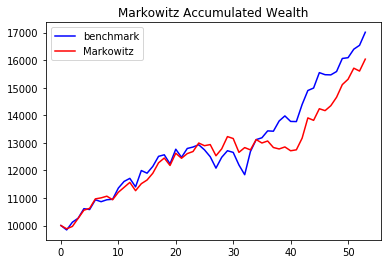

In [899]:
plt.figure(1)
plt.title("Markowitz Accumulated Wealth")
plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
plt.plot(range(len(portfolio_value)),portfolio_value,'r',label="Markowitz")
plt.legend()
plt.show()
markowitz_portfolio_value = portfolio_value

In [900]:
#######################
### BLACK LITTERMAN ###
#######################

#// rate_of_decay = 0
rate_of_decay = 1 - r_w_f_o_y_e**(sample_frequency/52.0)
benchmark_wealth = initial_wealth
wealth = initial_wealth
portfolio_value = [initial_wealth]
benchmark_value = [initial_wealth]
rebalance_dates = start + horizon*np.arange(number_rebalances)

for i in range(len(rebalance_dates)):
    trade_date = rebalance_dates[i]

    ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
    # Investor view is introduced by calling the investor_view function
    #// A,Omega,b = investor_view(Signal,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay)   
    #A,Omega,b = hybrid_investor_view(Signal1,Signal2,Signal3,At1,At2,At3,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay)
    A,Omega,b = double_investor_view(Signal1,Signal2,At1,At2,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay)
    A.dtype = 'float64'
    
    mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
    mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
    
    benchmark_risk = sqrt(quad_form(e,V))/(n+1)
    sigma = allowable_risk*benchmark_risk
    
    xx0 = x0
    xx = x
    # An optimal weight will be generated using blacklitterman instead of markowitz model 
    x0,x =  blacklitterman(mu0,mu,V,sigma,xx0,xx,trans_cost,A,Omega,b,tau=2)
    wealth = wealth*(x0+sum(x))
        
    total = x0+sum(x)
    x0 = x0/total
    x = x/total
    
    ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######
    
    returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
    
    multiplier = 1+mu0*x0+returns*x
    wealth = multiplier*wealth

    if(wealth<=0):
        break  
    
    x0 = (1+mu0)*x0/multiplier
    x = np.multiply(x,np.transpose(1+returns))/multiplier
    
    benchmark_x0 = (1+mu0)/(n+1)
    benchmark_x = (1+returns)/(n+1)
    
    z = rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost) 
    benchmark_wealth = benchmark_wealth*(n+1)*z
    
    portfolio_value.append(wealth)
    benchmark_value.append(benchmark_wealth)

In [901]:
print "your final bank account:", x0 
print "your final risky portfolio:", x 
print "your final wealth:", wealth 
print "benchmark final wealth:", benchmark_wealth 
BL_Ret=float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
print "your annualized rate of return:", BL_Ret
benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
print "benchmark annualized rate of return:", benchmark_annual_return
BlackLitterman_wealth = wealth

your final bank account: [[3.62972899e-12]]
your final risky portfolio: [[ 0.04696349]
 [ 0.02854922]
 [ 0.08534963]
 [ 0.08490244]
 [ 0.0831534 ]
 [ 0.08254274]
 [-0.01698844]
 [ 0.08138958]
 [-0.01646304]
 [ 0.08450232]
 [ 0.08156175]
 [-0.01722518]
 [ 0.08543709]
 [-0.01757517]
 [-0.01820418]
 [-0.01688845]
 [-0.01770228]
 [-0.01760583]
 [ 0.07752185]
 [ 0.08025104]
 [-0.01624244]
 [ 0.08211167]
 [ 0.00104649]
 [-0.01760978]
 [ 0.07775783]
 [-0.01818888]
 [ 0.08092822]
 [ 0.08265137]
 [-0.01828712]
 [-0.01763934]]
your final wealth: [[16372.28044042]]
benchmark final wealth: 17012.87826522332
your annualized rate of return: 0.125919642758
benchmark annualized rate of return: 0.136363562464


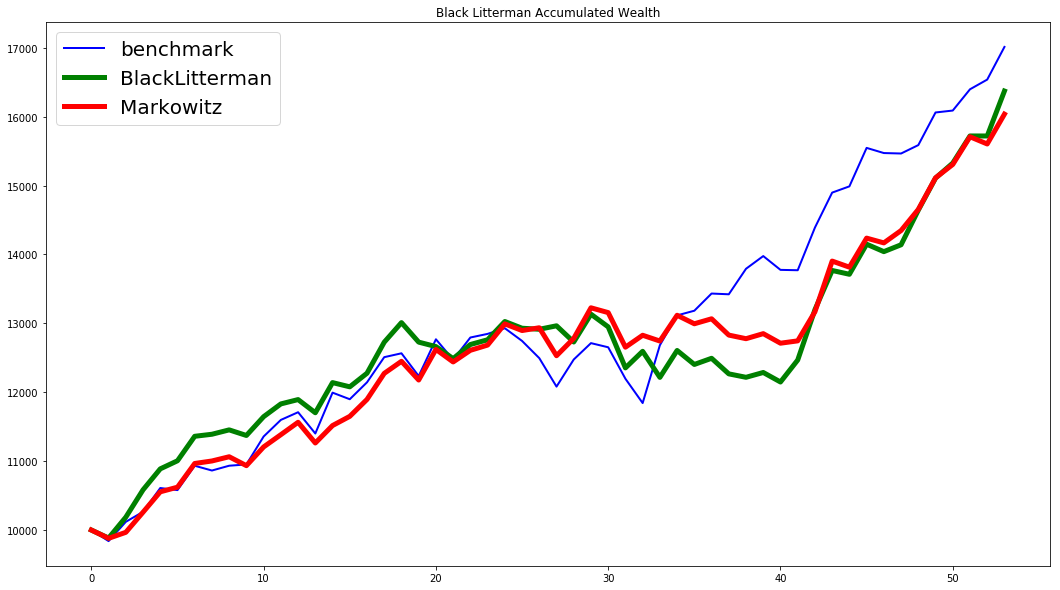

In [910]:
plt.figure(2)
plt.figure(figsize=(18,10))
plt.title("Black Litterman Accumulated Wealth")
plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark",lw = 2)
plt.plot(range(len(portfolio_value)),portfolio_value,'g',label="BlackLitterman",lw = 5)
plt.plot(range(len(portfolio_value)),markowitz_portfolio_value,'r',label="Markowitz",lw = 5)
plt.legend(prop={'size': 20})
plt.show()

In [903]:
print "Markowitz_wealth: ", float(Markowitz_wealth),'annualized rate of return:',markowitz_ret
print "BlackLitterman_wealth: ", float(BlackLitterman_wealth),'annualized rate of return:',BL_Ret
print "Benchmark: ", benchmark_wealth,'annualized rate of return:',benchmark_annual_return

Markowitz_wealth:  16036.9229944 annualized rate of return: 0.120327913525
BlackLitterman_wealth:  16372.2804404 annualized rate of return: 0.125919642758
Benchmark:  17012.87826522332 annualized rate of return: 0.136363562464
